# Capítulo 5 - Máquinas de Vetores de Suporte

Máquina de Vetores de Suporte (_Support Vector Machine - SVM_) é um modelo de aprendizado de máquina muito poderoso e versátil, capaz de realizar classificação linear ou não linear, regressão e até detecção de outlier. É um dos modelos mais populares em Aprendizado de Máquina e qualquer pessoa interessada em Aprendizado de Máquina deve tê-lo em sua caixa de ferramentas. Os SVMs são particularmente adequados para a classificação de conjuntos de dados complexos, mas de pequeno ou médio porte.

Este capítulo explicará os principais conceitos dos SVMs, como usá-los e como funcionam.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 5.1 Classificação Linear SVM

A ideia fundamental por trás dos SVMs é melhor explicada com algumas imagens. A figura abaixo mostra parte do conjunto de dados da íris que foi apresentado no final do Capítulo 4. As duas classes podem ser claramente separadas facilmente com uma linha reta (elas são linearmente separáveis). O gráfico à esquerda mostra os limites de decisão de três classificadores lineares possíveis. O modelo cujo limite de decisão é representado pela linha tracejada é tão ruim que nem mesmo separa as classes adequadamente. Os outros dois modelos funcionam perfeitamente neste conjunto de treinamento, mas seus limites de decisão chegam tão perto das instâncias que esses modelos provavelmente não funcionarão tão bem em novas instâncias. Em contraste, a linha sólida no gráfico à direita representa o limite de decisão de um classificador SVM; esta linha não apenas separa as duas classes, mas também fica o mais longe possível das instâncias de treinamento mais próximas. 

Você pode pensar em um classificador SVM ajustando-se à rua mais larga possível (representada pelas linhas tracejadas paralelas) entre as classes. Isso é chamado de classificação de grande margem.

In [2]:
from sklearn.svm import SVC
from sklearn import datasets

# Obtendo os valores do iris dataset
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  
y = iris["target"]

# Especificando apenas os casos setosa ou versicolor
setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# Inicializando e ajustando o modelo de classificação SVM
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Saving figure large_margin_classification_plot


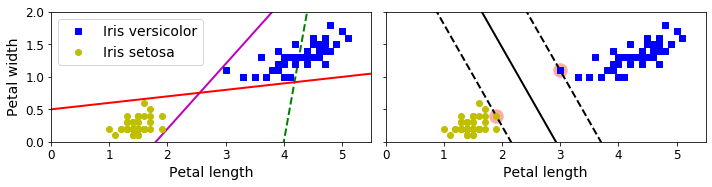

In [3]:
# Criando modelos de predição ruins para exemplificar
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

# Função para plotagem da rua do SVM
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # No limite de decisão, w0 * x0 + w1 * x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1 / w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

# Plotando o gráfico da esquerda com as predições ruins
plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

# Plotando o gráfico da direita com o modelo SVM
plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs")
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

Observe que adicionar mais instâncias de treinamento “fora da rua” não afetará de forma alguma o limite de decisão: é totalmente determinado (ou “suportado”) pelas instâncias localizadas na beira da rua. Essas instâncias são chamadas de vetores de suporte (eles estão circulados na figura abaixo).

Saving figure sensitivity_to_feature_scales_plot


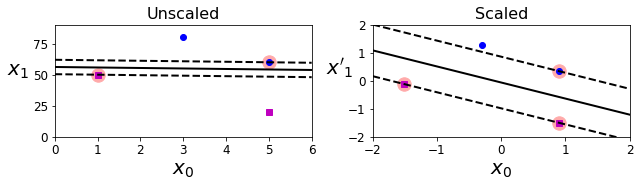

In [4]:
# Criando novos valores para exemplificação
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])

# Inicializando e ajustando o modelo de classificação SVM
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

# Plotagem da esquerda fora de escala 
plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys == 1], Xs[:, 1][ys == 1], "bo")
plt.plot(Xs[:, 0][ys == 0], Xs[:, 1][y s== 0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

# Plotagem da direita com escala
plt.subplot(122)
plt.plot(X_scaled[:, 0][ys == 1], X_scaled[:, 1][ys == 1], "bo")
plt.plot(X_scaled[:, 0][ys == 0], X_scaled[:, 1][ys == 0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

## 5.2 Classificação de Margem Suave

Se impormos estritamente que todas as instâncias estejam fora da rua e no lado direito, isso é chamado de classificação de margem rígida. Existem dois problemas principais com a classificação de margem rígida. Em primeiro lugar, ele só funciona se os dados forem linearmente separáveis e, em segundo lugar, é bastante sensível a outliers. A Figura abaixo mostra o conjunto de dados da íris com apenas um outlier adicional: à esquerda, é impossível encontrar uma margem rígida e à direita o limite de decisão acaba muito diferente do que vimos na figura sem o outlier e provavelmente não generalizará também.

Saving figure sensitivity_to_outliers_plot


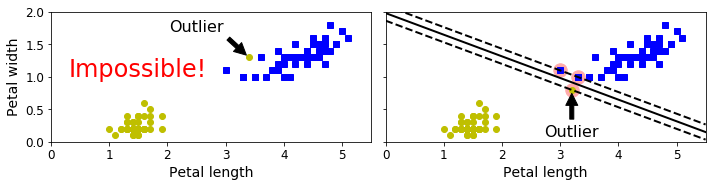

In [5]:
# Acrescentando outliers no conjunto de dados
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])

Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

# Inicializando e ajustando o modelo de classificação SVM
svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

# Plotagem da esquerda evidenciando que é impossível formular a rua
plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

# Plotagem da direita com um limite muito diferente do apresentado anteriormente (não generalizável)
plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.show()

Para evitar esses problemas, é preferível usar um modelo mais flexível. O objetivo é encontrar um bom equilíbrio entre manter a rua o mais larga possível e limitar as violações de margem (ou seja, casos que acabam no meio da rua ou mesmo do lado errado). Isso é chamado de classificação de margem suave.

Nas classes SVM do Scikit-Learn, você pode controlar esse equilíbrio usando o hiperparâmetro `C`: um valor C menor leva a uma rua mais ampla, mas mais violações de margem. A figura abaixo mostra os limites de decisão e as margens de dois classificadores SVM de margem suave em um conjunto de dados não linearmente separável. À esquerda, usando um valor de C baixo, a margem é bem grande, mas muitos casos acabam na rua. À direita, usando um valor C alto, o classificador comete menos violações de margem, mas acaba com uma margem menor. No entanto, parece provável que o primeiro classificador generalize melhor: na verdade, mesmo neste conjunto de treinamento, ele comete menos erros de previsão, já que a maioria das violações de margem estão na verdade no lado correto do limite de decisão.

O código Scikit-Learn a seguir carrega o conjunto de dados da íris, dimensiona os recursos e, em seguida, treina um modelo SVM linear (usando a classe LinearSVC com C = 1) para detectar flores de Iris-Virginica.

In [6]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# Obtendo os valores do iris dataset
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

# Formulando um Pipeline para a formulação do modelo
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
])

svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [7]:
# Realizando uma predição teste
svm_clf.predict([[5.5, 1.7]])

array([1.])

In [8]:
# Formulando dois Pipelines para comparação das oscilações do hiperparâmetro C

scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

/Users/ageron/miniconda3/envs/tf2b/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [9]:
# Converter para parâmetros fora de escala
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])

w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_

svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])

svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Encontrando vetores de suporte (LinearSVC não faz isso automaticamente)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()

svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

Saving figure regularization_plot


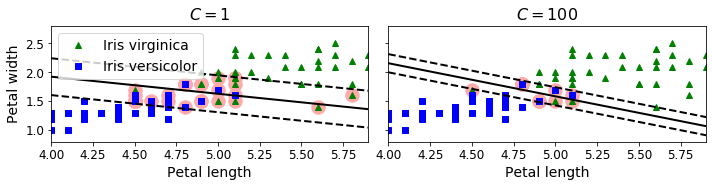

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

# Plotando imagem da esquerda com C = 1
plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

# Plotando imagem da direita com C = 100
plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

## 5.3 Classificação Não-Linear SVM

Embora os classificadores SVM lineares sejam eficientes e funcionem surpreendentemente bem em muitos casos, muitos conjuntos de dados não estão nem perto de serem linearmente separáveis. Uma abordagem para lidar com conjuntos de dados não lineares é adicionar mais recursos, como recursos polinomiais. Em alguns casos, isso pode resultar em um conjunto de dados separável linearmente. Considere o gráfico à esquerda na figura abaixo: ele representa um conjunto de dados simples com apenas um recurso x1. Este conjunto de dados não é linearmente separável, como você pode ver. Mas se você adicionar um segundo recurso x2 = (x1)^2, o conjunto de dados 2D resultante é perfeitamente linearmente separável.

Saving figure higher_dimensions_plot


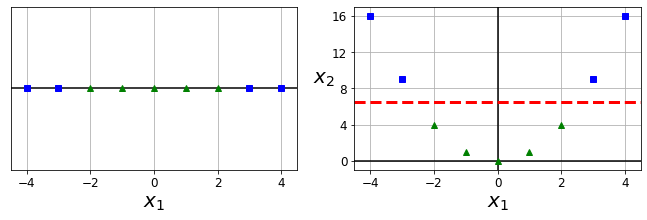

In [11]:
# Gerando valores para exemplificação
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

# Plotando gráfico da esquerda
plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

# Plotando gráfico da esquerda
plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

plt.show()

Para implementar essa ideia usando o Scikit-Learn, você pode criar um Pipeline contendo um transformador `PolynomialFeatures`, seguido por um `StandardScaler` e um `LinearSVC`. 

Vamos testar isso no conjunto de dados das luas: este é um conjunto de dados de brinquedo para classificação binária em que os pontos de dados são modelados como dois semicírculos intercalados. Você pode gerar este conjunto de dados usando a função `make_moons()`:

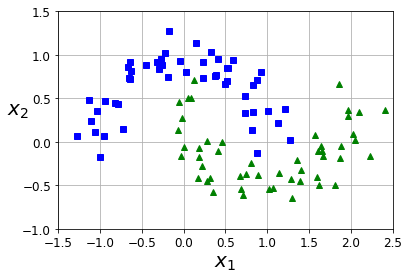

In [12]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [13]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

Saving figure moons_polynomial_svc_plot


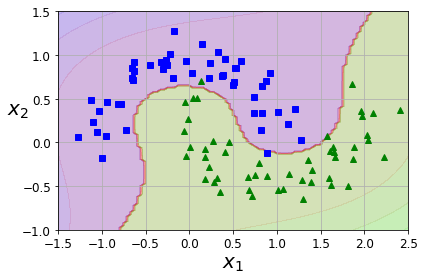

In [14]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

## 5.4 Kernel Polinomial

Adicionar recursos polinomiais é simples de implementar e pode funcionar muito bem com todos os tipos de algoritmos de aprendizado de máquina (não apenas SVMs), mas em um baixo grau polinomial ele não pode lidar com conjuntos de dados muito complexos e com um alto grau polinomial ele cria um grande número de _features_, tornando o modelo muito lento.
Felizmente, ao usar SVMs, você pode aplicar uma técnica matemática quase milagrosa chamada truque do kernel. Esta técnica torna possível obter o mesmo resultado como se você adicionasse muitos _features_ polinomiais, mesmo com polinômios de grau muito alto, sem realmente ter que adicioná-los. Portanto, não há explosão combinatória do número de _features_, uma vez que você não adiciona nenhuma _feature_. Este truque é implementado pela classe SVC. Vamos testá-lo no conjunto de dados das luas:

In [15]:
from sklearn.svm import SVC

# Ajustando modelo a um truque do kernel de terceiro grau
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

Este código treina um classificador SVM usando um kernel polinomial de 3º grau. Ele é representado à esquerda da na figura abaixo. À direita está outro classificador SVM usando um kernel polinomial de 10º grau. Obviamente, se o seu modelo estiver com overfitting, você pode querer reduzir o grau polinomial. Por outro lado, se for insuficiente, você pode tentar aumentá-lo. O hiperparâmetro `coef0` controla o quanto o modelo é influenciado por polinômios de alto grau versus polinômios de baixo grau.

In [16]:
# Ajustando modelo a um truque do kernel de décimo grau
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])

poly100_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=100,
  decision_function_shape='ovr', degree=10, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

Saving figure moons_kernelized_polynomial_svc_plot


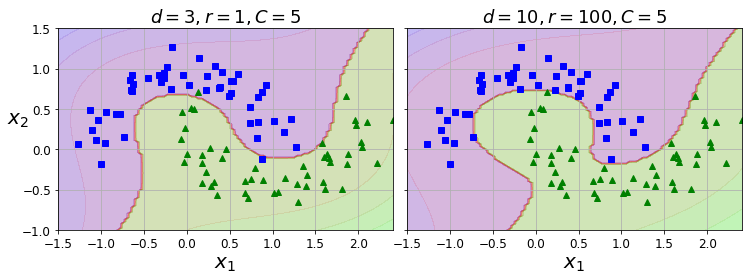

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

# Gerando a figura com o truque do kernel de terceiro grau
plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

# Gerando a figura com o truque do kernel de décimo grau
plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

plt.show()

## 5.5 Adicionando _Features_ de Similaridade

Outra técnica para lidar com problemas não lineares é adicionar _features_ calculadas usando uma função de similaridade que mede o quanto cada instância se assemelha a um determinado ponto de referência. Por exemplo, vamos pegar o conjunto de dados unidimensional discutido anteriormente e adicionar dois marcos a ele em x1 = –2 e x1 = 1 (veja o gráfico à esquerda na figura abaixo). A seguir, vamos definir a função de similaridade como sendo a Função de Base Radial Gaussiana (RBF) com γ = 0,3. É uma função em forma de sino que varia de 0 (muito longe do ponto de referência) a 1 (no ponto de referência). Agora estamos prontos para calcular as novas _features_. Por exemplo, vejamos a instância x1 = –1: ela está localizada a uma distância de 1 do primeiro ponto de referência e 2 do segundo ponto de referência. Portanto, suas novas _features_ são x2 = exp (–0,3 × 12) ≈ 0,74 e x3 = exp (–0,3 × 22) ≈ 0,30. O gráfico à direita da figura abaixo mostra o conjunto de dados transformado (eliminando as _features_ originais). Como você pode ver, agora é linearmente separável.

Saving figure kernel_method_plot


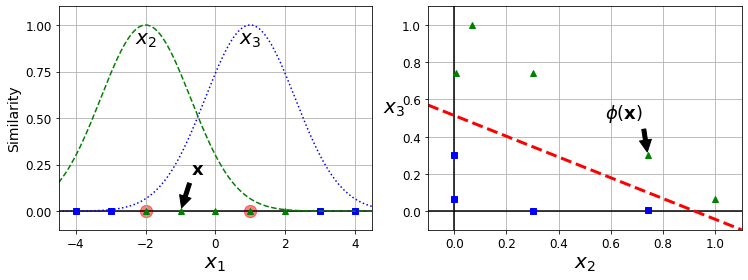

In [18]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

# Gerando gráfico da esquerda
plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

# Gerando gráfico da direita
plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

plt.show()

Você pode se perguntar como selecionar os marcos. A abordagem mais simples é criar um ponto de referência no local de cada uma das instâncias do conjunto de dados. Isso cria muitas dimensões e, portanto, aumenta as chances de que o conjunto de treinamento transformado seja linearmente separável. A desvantagem é que um conjunto de treinamento com m instâncias e n _features_ é transformado em um conjunto de treinamento com m instâncias e m _features_ (assumindo que você elimine as _features_ originais). Se o seu conjunto de treinamento for muito grande, você acabará com um número igualmente grande de _features_.

In [19]:
x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


## 5.6 Kernel RBF Gaussiano

Assim como o método de recursos polinomiais, o método de recursos de similaridade pode ser útil com qualquer algoritmo de aprendizado de máquina, mas pode ser caro computacionalmente para calcular todos as _features_ adicionais, especialmente em grandes conjuntos de treinamento. No entanto, mais uma vez, o truque do kernel faz sua mágica de SVM: torna possível obter um resultado semelhante, como se você tivesse adicionado muitas _features_ de similaridade, sem realmente ter que adicioná-los. Vamos tentar o kernel RBF gaussiano usando a classe SVC:

In [20]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Este modelo é representado na parte inferior esquerda da abaixo. Os outros gráficos mostram modelos treinados com diferentes valores de hiperparâmetros gama (`γ`) e `C`. Aumentar gama torna a curva em forma de sino mais estreita e, como resultado, o intervalo de influência de cada instância é menor: o limite de decisão acaba sendo mais irregular, oscilando em torno de instâncias individuais. Por outro lado, um pequeno valor de gama torna a curva em forma de sino mais larga, de modo que as instâncias têm uma faixa maior de influência e o limite de decisão acaba mais suave. Portanto, γ atua como um hiperparâmetro de regularização: se o seu modelo estiver com overfitting, você deve reduzi-lo, e se estiver com underfitting, você deve aumentá-lo.

Saving figure moons_rbf_svc_plot


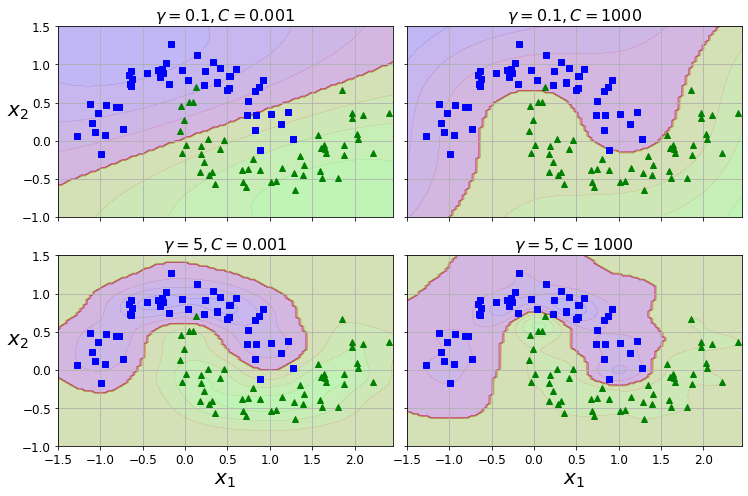

In [21]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

## 5.7 Regressão SVM

Como mencionamos anteriormente, o algoritmo SVM é bastante versátil: não apenas suporta classificação linear e não linear, mas também suporta regressão linear e não linear. O truque é inverter o objetivo: em vez de tentar encaixar a maior rua possível entre duas classes, enquanto limita as violações de margem, a Regressão SVM tenta encaixar tantas instâncias quanto possível na rua, enquanto limita as violações de margem (ou seja, instâncias fora da rua). A largura da rua é controlada por um hiperparâmetro `ϵ`. A figura abaixo mostra dois modelos de regressão SVM linear treinados em alguns dados lineares aleatórios, um com uma grande margem (ϵ = 1,5) e o outro com uma pequena margem (ϵ = 0,5).

In [22]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [23]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=42, tol=0.0001, verbose=0)

In [24]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

Saving figure svm_regression_plot


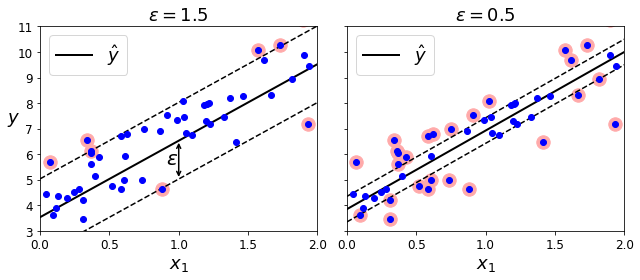

In [25]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

In [26]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

Para lidar com tarefas de regressão não linear, você pode usar um modelo SVM kernelizado. Por exemplo, a figura abaixo mostra a Regressão SVM em um conjunto de treinamento quadrático aleatório, usando um kernel polinomial de 2° grau. Há pouca regularização no gráfico esquerdo (ou seja, um grande valor C) e muito mais regularização no gráfico direito (ou seja, um pequeno valor C).

O código a seguir produz o modelo representado à esquerda da abaixo usando a classe SVR do Scikit-Learn (que oferece suporte ao truque do kernel). A classe SVR é o equivalente de regressão da classe SVC, e a classe LinearSVR é o equivalente de regressão da classe LinearSVC. A classe LinearSVR escala linearmente com o tamanho do conjunto de treinamento (assim como a classe LinearSVC), enquanto a classe SVR fica muito lenta quando o conjunto de treinamento fica grande (assim como a classe SVC).

In [27]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [28]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Saving figure svm_with_polynomial_kernel_plot


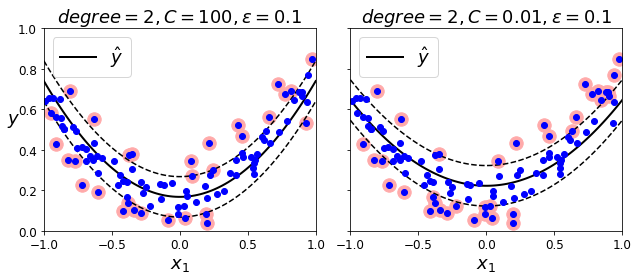

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()